# T001 · 化合物数据获取 (ChEMBL)

## 课程目标

在此notebook中，我们将会学到更多有关CHEMBL数据库的知识，以及如何从CHEMBL数据库中提取数据,例如:特定靶点的(化合物，活性)数据对。这些数据集合可以用在很多化学信息学的下游任务中，如相似性搜索、聚类或机器学习中。

我们的工作将包括寻找针对特定靶点进行测试的化合物，并筛选可用的生物活性数据。

### *原理部分*

* ChEMBL 数据库
    * ChEMBL web services
    * ChEMBL web resource client
* 化合物活性衡量指标
    * IC50 衡量
    * pIC50 值

### *实战部分*
    
**目标: 针对特定靶点获取小分子的活性数据列表**

* 连接ChEMBL数据库
* 获取靶点数据(示例: EGFR激酶)
    * 拉取并下载靶点数据
    * 选择靶点ChEMBL ID
* 获取活性数据
    * 拉取并下载特定靶点的生物活性数据
    * 预处理和筛选生物活性数据、
* 获取化合物数据
    * 拉取并下载化合物数据
    * 预处理和过滤化合物数据
* 输出 生物活性-化合物 数据
    * 合并活性和化合物数据, 并添加pIC50值
    * 画出pIC50值分布图
    * 保持在ChEMBL 27 版本
    * 保存结果到文件

### 参考文献

* ChEMBL bioactivity database: [Gaulton *et al.*, <i>Nucleic Acids Res.</i> (2017), 45(Database issue), D945–D954](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5210557/)
* ChEMBL web services: [Davies *et al.*, <i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881) 
* [ChEMBL web-interface](https://www.ebi.ac.uk/chembl/)
*  GitHub [ChEMBL web rescource client](https://github.com/chembl/chembl_webresource_client)
* The EBI RDF platform: [Jupp *et al.*, <i>Bioinformatics </i> (2014), 30(9), 1338-9](https://www.ncbi.nlm.nih.gov/pubmed/24413672)
* Info on half maximal inhibitory concentration: [(p)IC50](https://en.wikipedia.org/wiki/IC50)
* [UniProt website](https://www.uniprot.org/)

## 原理

### ChEMBL 数据库
![ChEMBL web service schema](images/CHEMBL_cover.png)
>"ChEMBL 是一个人工整理的生物活性分子数据库，这些分子具有类似药物的属性。它汇集了化学、生物活性和基因组数据，以帮助将基因组信息转化为有效的新药物." ([ChEMBL 网站](https://www.ebi.ac.uk/chembl/))

### 化合物活性衡量指标

#### IC50 值

* [半抑制浓度(Half maximal inhibitory concentration)](https://baike.baidu.com/item/%E5%8D%8A%E6%8A%91%E5%88%B6%E6%B5%93%E5%BA%A6/6174649?fr=ge_ala)
* 表明需要多少特定药物或其他物质来抑制某个生物过程的一半

![Wiki_Example_IC50_curve_demonstrating_visually_how_IC50_is_derived](images/Wiki_Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png)

*Fiugure 2:* 如何推导 IC50 值的示例：
(i) 将抑制数据排列在 y 轴上，将浓度的对数排列在 x 轴上。 (ii) 确定最大和最小抑制。 (iii) IC50 是曲线通过 50% 抑制水平时的浓度。 图片 ["Example IC50 curve demonstrating visually how IC50 is derived"](https://en.wikipedia.org/wiki/IC50#/media/File:Example_IC50_curve_demonstrating_visually_how_IC50_is_derived.png)  由 JesseAlanGordon 创作，遵循 [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) 许可协议。


#### pIC50 值

* 为了便于比较具有大范围值并且以不同单位（M, nM, ...）给出的IC50值，通常使用pIC50值。
* pIC50 是将IC50值转换为摩尔单位后的负对数：
    $ pIC_{50} = -log_{10}(IC_{50})$，其中 $ IC_{50} $ 以摩尔单位M表示。
* 更高的pIC50值表示药物的效力呈指数级增长。
* 注意，转换可以根据各自的IC50单位进行调整，例如对于纳摩尔nM：$pIC_{50} = -log_{10}(IC_{50}*10^{-9})= 9-log_{10}(IC_{50}) $

其他活性度量：

除了IC50和pIC50，还使用其他生物活性度量方法，例如平衡常数 [KI](https://en.wikipedia.org/wiki/Equilibrium_constant) 和半最大有效浓度 [EC50](https://en.wikipedia.org/wiki/EC50)。


## 练习

在接下来的内容中，我们想要下载所有已针对我们感兴趣的目标——**表皮生长因子受体激酶**（[**EGFR**](https://www.uniprot.org/uniprot/P00533)）进行测试的分子。

### 连接CHEMBL数据库

首先，导入ChEMBL web resource client和其他Python库

In [2]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

接下来创建资源对象API

In [4]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [5]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

### 获取靶点数据(EGFR 激酶)

* 从[UniProt website](https://www.uniprot.org/)获取目标靶点的 UniProt ID(EGFR kinase:  [P00533](http://www.uniprot.org/uniprot/P00533))
* 使用UniProt ID获取靶点信息

PS：你也可以利用UniProt ID获取其他感兴趣的靶点

In [6]:
uniprot_id = "P00533"

#### 从ChEMBL拉取靶点数据

In [7]:
# 从CHEMBL数据库只获取定义的靶点信息
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


#### 从CHEMBL数据库下载靶点信息

查询结果存储在`targets`变量中, 是一个 `QuerySet`, 也即结果不会直接从CHEMBL获取，只有请求时才会有(在这里我们使用 `pandas.DataFrame.from_records`方法)。


In [8]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
2,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,CHEMBL2111431,PROTEIN FAMILY
3,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
4,Homo sapiens,MER intracellular domain/EGFR extracellular do...,CHEMBL3137284,CHIMERIC PROTEIN
5,Homo sapiens,Protein cereblon/Epidermal growth factor receptor,CHEMBL4523680,PROTEIN-PROTEIN INTERACTION
6,Homo sapiens,EGFR/PPP1CA,CHEMBL4523747,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,VHL/EGFR,CHEMBL4523998,PROTEIN-PROTEIN INTERACTION
8,Homo sapiens,Baculoviral IAP repeat-containing protein 2/Ep...,CHEMBL4802031,PROTEIN-PROTEIN INTERACTION


#### 选择靶点(靶点ChEMBL ID)

在检查了上述表格后，我们选择：

`CHEMBL203`: 这是一个蛋白单体，代表人类表皮生长因子受体(EGFR, 也叫erbB1) 

In [9]:
target = targets.iloc[0]
target

organism                                      Homo sapiens
pref_name           Epidermal growth factor receptor erbB1
target_chembl_id                                 CHEMBL203
target_type                                 SINGLE PROTEIN
Name: 0, dtype: object

接下来保存选择的ChEMBL ID

In [10]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL203


### 获取生物活性数据

现在，我们想要查询定义靶点的生物活性数据

#### 从CHEMBL靶点获取生物活性数据

在这一步，我们获取活性数据且仅考虑：

* 人类蛋白;
* IC50活性数据;
* 关系为`'='`
* 结合数据(文章类型 `'B'`).

In [11]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 10924, <class 'chembl_webresource_client.query_set.QuerySet'>


我们的生物活性数据集中的每个条目包含以下信息：

In [12]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 32260,
 'assay_chembl_id': 'CHEMBL674637',
 'assay_description': 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL68920',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '41.0',
 'target_chembl_id': 'CHEMBL203',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.041'}

#### 从CHEMBL下载活性数据

最后，我们以 `pandas` 的 `DataFrame` 形式下载了 `QuerySet`。

> **注意**：这一步不应该超过2分钟，如果超过了，请尝试从 "从 ChEMBL 获取目标的生物活性数据" 重新运行所有单元格，或者阅读下面的消息：

<details>
    
<summary>加载数据的本地版本（如果您在获取数据时遇到任何问题）</summary>
    
如果您在查询 ChEMBL 数据库时遇到困难，我们也提供了您将在下面单元格构建的结果 dataframe。如果您想使用保存的版本，请使用以下代码来获取 `bioactivities_df`：

```python
# 将下面单元格的第一行替换为这行代码
bioactivities_df = pd.read_csv(DATA / "EGFR_bioactivities_CHEMBL27.csv.zip", index_col=0)
```

</details>


In [ ]:
# bioactivities_df = pd.read_csv(DATA / "EGFR_bioactivities_CHEMBL27.csv.zip", index_col=0)

bioactivities_df = pd.DataFrame.from_dict(bioactivities)

print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df

注意，前两行描述了相同的活性数据，我们会在接下来的步骤中移除这些数据。

In [14]:
bioactivities_df["units"].unique()

array(['uM', 'nM', 'pM', 'M', "10'3 uM", "10'1 ug/ml", 'ug ml-1',
       "10'-1microM", "10'1 uM", "10'-1 ug/ml", "10'-2 ug/ml", "10'2 uM",
       "10'-3 ug/ml", "10'-2microM", '/uM', "10'-6g/ml", 'mM', 'umol/L',
       'nmol/L', "10'-10M", "10'-7M", 'nmol', '10^-8M'], dtype=object)

In [15]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


#### 预处理和筛选

1. 将 `standard_value` 从 `object` 转为 `float`
2. 删除缺失值
3. 只保留 `standard_unit == nM`
4. 删除重复数据
5. 重新设置 `DataFrame` 索引
6. 重命名列

**1. 将 `standard_value` 从 `object` 转为 `float`**


In [16]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [17]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

**2. 删除缺失值**

使用 `inplace=True` 参数和`dropna`方法删除缺失值

In [18]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (10923, 11)


**3. 只保留 `standard_unit == nM`** 

我们只保留`nM`单位,所以删除其他单位 

In [19]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM' 'ug.mL-1' '/uM']
Number of non-nM entries:    69


In [20]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [21]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (10854, 11)


**4. 删除重复数据**

有时相同的小分子 (`molecule_chembl_id`) 经常被测试多次，所以我们只保留在表格中第一次出现的数据。

In [22]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (7081, 11)


**5. 重新设置 `DataFrame` 索引**

由于我们删除了一些行，但我们稍后想要连续地迭代索引，我们重置索引以保持连续性。

In [23]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


**6. 重命名列**

In [24]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


In [25]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (7081, 11)


### 获取化合物数据

我们已经有了一个`DataFrame`，其中包含了所有针对EGFR测试的分子（以及相应的测量生物活性）。

现在，我们想要获取与各自生物活性ChEMBL ID相关联的分子结构。

#### 从ChEMBL获取化合物数据

让我们看看那些我们定义了生物活性数据的ChEMBL中的化合物：获取与筛选的生物活性数据相关联的化合物的ChEMBL ID和结构。


In [26]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

#### 从ChEMBL下载化合物数据

我们想要将`QuerySet`对象导出到`pandas.DataFrame`。考虑到数据量，**这可能需要一些时间。** 因此，我们首先将通过`tqdm`获取记录列表，这样我们就可以有一个漂亮的进度条和一些预计完成时间。然后，我们可以将化合物列表传递给DataFrame。


In [30]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/7081 [00:00<?, ?it/s]

In [31]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (7081, 2)


In [32]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL10,{'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-...
2,CHEMBL6976,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncn(C)...
3,CHEMBL7002,{'canonical_smiles': 'CC1(COc2ccc(CC3SC(=O)NC3...
4,CHEMBL414013,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncnc(O...


#### 预处理和过滤化合物数据

1. 删除有缺失条目的记录
2. 通过分子_chembl_id删除重复的分子
3. 获取具有标准SMILES的分子

**1. 删除有缺失条目的记录**

In [33]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (7074, 2)


**2. 删除重复的分子**

In [34]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (7074, 2)


**3. 获取具有标准SMILES的分子**

到目前为止，我们有多种不同的分子结构表示。我们只想保留标准SMILES表示。

In [35]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [36]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (7074, 2)


再次检查：移除所有没有标准SMILES字符串的分子。

In [37]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (7074, 2)


### 输出（生物活性-化合物）数据
**化合物和生物活性数据的总结**


In [38]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 7081


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [39]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 7074


Index(['molecule_chembl_id', 'smiles'], dtype='object')

#### 合并数据集

根据化合物的ChEMBL ID (`molecule_chembl_id`)，将`bioactivities_df`和`compounds_df`中的值合并到`output_df`中，保留以下列：

* ChEMBL ID: `molecule_chembl_id`
* SMILES: `smiles`
* 单位: `units`
* IC50: `IC50`


In [40]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 7074 entries.


In [41]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [42]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1
5,CHEMBL77085,96000.0,nM,N#CC(C#N)=Cc1cc(O)ccc1[N+](=O)[O-]
6,CHEMBL443268,5310.0,nM,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...
7,CHEMBL76979,264000.0,nM,COc1cc(/C=C(\C#N)C(=O)O)cc(OC)c1O
8,CHEMBL76589,125.0,nM,N#CC(C#N)=C(N)/C(C#N)=C/c1ccc(O)cc1
9,CHEMBL76904,35000.0,nM,N#CC(C#N)=Cc1ccc(O)c(O)c1


#### 添加 pIC50 值

可以看到，低IC50值很难读（值分布在多个尺度上），这就是为什么我们将IC50值转换为pIC50。

In [43]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [44]:
# 对化合物的DataFrame的每一行应用转换
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [45]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,6.769551
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879


#### 绘制化合物数据

让我们看看我们收集的数据集。

首先，我们绘制pIC50值的分布情况。


array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

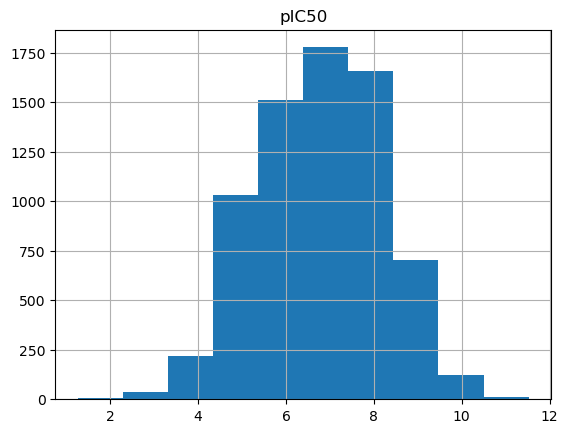

In [46]:
output_df.hist(column="pIC50")

在接下来的步骤中，我们将向`DataFrame`添加一列用于RDKit分子对象，并查看具有最高pIC50值的分子结构。


In [47]:
# 添加分子列
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [48]:
#按 pIC50值排列小分子
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# 重设索引
output_df.reset_index(drop=True, inplace=True)

展示三个活性最高的分子，即具有最高pIC50值的分子。

In [49]:
output_df.drop("smiles", axis=1).head(3)

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL63786,0.003,nM,11.522879,<rdkit.Chem.rdchem.Mol object at 0x7fcdd0bec7b0>
1,CHEMBL53711,0.006,nM,11.221849,<rdkit.Chem.rdchem.Mol object at 0x7fcdd0be3e40>
2,CHEMBL35820,0.006,nM,11.221849,<rdkit.Chem.rdchem.Mol object at 0x7fcdd0bd6e40>


In [50]:
# 准备保存数据集：删除 ROMol 列
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (7074, 5)


#### 将输出数据冻结到 ChEMBL 27

这是一个技术步骤：通常，我们会使用我们刚刚创建的数据集（最新数据集）继续工作。

然而，在 TeachOpenCADD 平台上，我们倾向于将数据集冻结到某个特定的 ChEMBL 版本（例如 [ChEMBL 27](http://doi.org/10.6019/CHEMBL.database.27)），以便本教程和其他教程在未来不会发生变化（这有助于我们维护教程）。


<div class="alert alert-block alert-info">

<b>Note:</b> 如果您希望在最新数据集上运行这个笔记本，或者如果您想将其用于另一个目标，请注释掉下面的单元格。

</div>

In [51]:
output_df = pd.read_csv(
    DATA / "EGFR_compounds_ea055ef.csv", index_col=0, float_precision="round_trip"
)
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910


In [52]:
print(f"DataFrame shape: {output_df.shape}")
# NBVAL_CHECK_OUTPUT

DataFrame shape: (5568, 5)


#### 将输出数据写入文件

我们希望在接下来的教程中使用这个生物活性-化合物数据集，因此我们将数据保存为 `csv` 文件。
请注意，在保存数据时，建议删除分子列（该列仅包含分子的图像）。


In [53]:
output_df.to_csv(DATA / "EGFR_compounds.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910


In [54]:
print(f"DataFrame shape: {output_df.shape}")
# NBVAL_CHECK_OUTPUT

DataFrame shape: (5568, 5)


## 讨论

在本教程中，我们从 ChEMBL 数据库中收集了我们感兴趣目标的生物活性数据。
我们对数据集进行了筛选，只包含具有测量 IC50 生物活性值的分子。

请注意，ChEMBL 数据来自不同的来源。化合物数据是由世界各地的不同实验室和人员生成的。因此，在使用这个数据集进行预测时，我们必须谨慎。在解释结果以及确定我们对预测的信心程度时，始终重要的是要考虑数据的来源以及数据生产测定的一致性。

在接下来的教程中，我们将通过 Lipinski 的五规则和不想要的子结构来过滤我们获得的数据。另一个重要步骤是对分子数据进行*清洗*。由于这在我们任何教程中都没有展示（尚未），我们希望引用 [Standardiser 库](https://github.com/flatkinson/standardiser) 或 [MolVS](https://molvs.readthedocs.io/en/latest/) 作为这项任务的有用工具。


## 课后思考

* 在这个教程中，我们从 ChEMBL 下载了分子和生物活性数据。ChEMBL 数据库还有什么其他用途？
* IC50 和 EC50 之间有什么区别？
* 我们可以如何使用从 ChEMBL 提取的数据？

## 本文作者

- Svetlana Leng, CADD seminar 2017, Volkamer lab, Charité/FU Berlin 
- Paula Junge, CADD seminar 2018, Volkamer lab, Charité/FU Berlin
- Dominique Sydow, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)
- Andrea Volkamer, 2020, [Volkamer lab, Charité](https://volkamerlab.org/)
- Yonghui Chen, 2020, [Volkamer lab, Charité](https://volkamerlab.org/)

## 翻译校对
- ByteTora